# Análisis de Configuraciones
En esta notebook se analizarán los resultados de las distintas configuraciones de conversión de modelos de redes neuronales construidos en Keras a HLS para sintetizar un IP core para FPGAs de Xilinx.<br>
Se pondrá el foco en ver el impacto de variar la precisión numérica con la que se implementa la red neuronal en la FPGA (parámetro **precision**) y luego cómo impacta la paralelización (parámetro **reuse factor**), que permite definir la cantidad de ciclos de reloj permitidos para ejecutar la inferencia en el modelo.<br>

El procedimiento para generar las distintas configuraciones, entrenamiento del modelo, conversión y síntesis del HDL, es ejecutar el script **run_config_iterations.py** en donde se puede generar una lista de los valores a iterar para cubrir el rango de variación de uno o más parámetros. El resultado de este script es la compilación y entrenamiento del modelo a usar (carpeta *output* y/o *model* si se hizo un checkout del mismo), generación de los distintos archivos de configuración para la conversión *Keras to HLS* (carpeta *configs*), los IP cores sintetizados (carpeta *ip*) y los reportes de utilización de recursos y performance del core implementado (carpeta *ouputs* en formato *JSON*).

In [26]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt

cwd = os.getcwd()
DATA_FOLDER = cwd + '/data/'
OUTPUT_FOLDER = cwd + '/outputs/'
MODELS_FOLDER = cwd + '/models/'
CONFIG_FOLDER = cwd + '/configs/'
FPGA_FOLDER = cwd + '/fpga/'
IPS_FOLDER = cwd + '/ip/'

## Reuse Factor
En esta sección se variará el parámetro *Reuse Factor*, el cuál determina la cantidad de ciclos en que se paraleliza el cálculo de una etapa (layer) de la red neuronal. Se dejará fija la precisión numérica.

A continuación, generaremos los nombres de las reportes que se generaron al variar este parámetro:

In [27]:
MODEL_NAME = 'ANN50x50'
PRECISION = [[24,6]]
REUSE_FACTOR = [1,2,3,4,8,12,16]
report_files = []

for p in PRECISION:
    for r in REUSE_FACTOR:
        ITERATION_NAME = '{model_name}_p{p0}_{p1}_r{r}'.format(
            model_name=MODEL_NAME,
            p0=p[0],
            p1=p[1],
            r=r
        )  
        report_files.append( OUTPUT_FOLDER + ITERATION_NAME + '_report.json' )

Ahora construimos un arreglo de diccionarios con la información de cada reporte. Se aprovecha para mostrar un ejemplo de un reporte en formato diccionario.

In [28]:
reports = []
for report_file in report_files:
    json_file = open(report_file)
    json_str = json_file.read()
    json_dict = json.loads(json_str)
    reports.append(json_dict)

reports[0]

{'Target': {'Family': 'zynquplus',
  'Device': 'xazu7eg',
  'Package': '-fbvb900',
  'Speed': '-1-i'},
 'Latency': {'LatencyBest': '3',
  'LatencyAvg': '3',
  'LatencyWorst': '3',
  'PipelineII': '1',
  'PipelineDepth': '4',
  'PipelineType': 'function'},
 'Timing': {'Target': '24.00', 'Uncertainty': '3.00', 'Estimate': '17.067'},
 'Area': {'BRAM_18K': '18',
  'DSP48E': '4600',
  'FF': '2073',
  'LUT': '106522',
  'URAM': '0'},
 'Calc': {'InferenceTime': 7.200000000000001e-08,
  'InferenceTimeBest': 5.1200999999999996e-08,
  'SamplesPerSecond': 13888888.888888886,
  'SamplesPerSecondBest': 19530868.537723873,
  'ClkFreq': 41666666.666666664,
  'ClkFreqMax': 58592605.613171615},
 'params': {'model_name': 'ANN50x50',
  'dataset': 'Landsat',
  'x_data_proc': 'standarization',
  'y_data_proc': 'one-hot',
  'fpga_data_format': '%.6f',
  'epochs': 10,
  'batch_size': 32,
  'part': 'xazu7eg-fbvb900-1-i',
  't_clk': 24,
  'io_type': 'io_parallel',
  'precision': [[24, 6]],
  'reuse_factor': [1

Analizamos la **latency average** al variar el *reuse factor*. Como se observa en la siguiente figura, la latencia se incrementa (casi) linealmente en función del factor, puesto que se penzaliza la paralelización para reutilizar recursos de la FPGA.

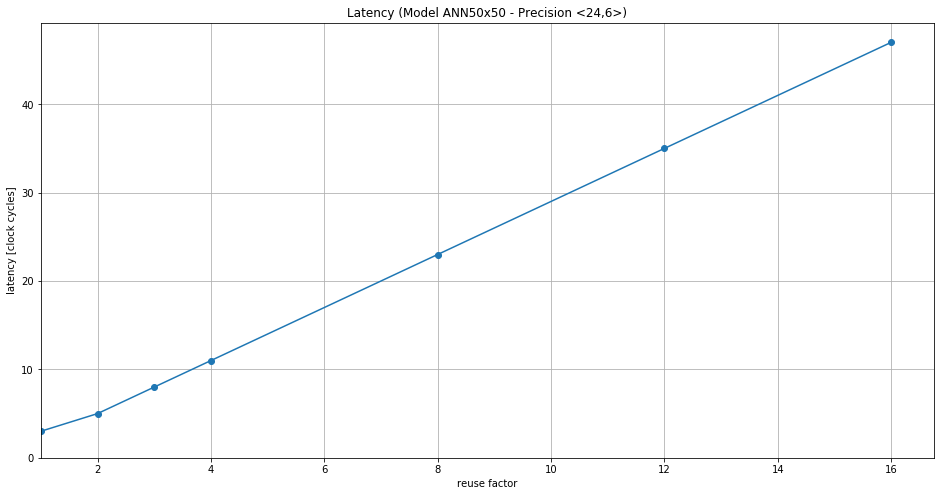

In [29]:
latency_avg = []
for i in range(len(REUSE_FACTOR)):
    latency_avg.append(int(reports[i]['Latency']['LatencyAvg']))

fig = plt.figure(figsize=(16,8))
plt.plot(REUSE_FACTOR, latency_avg, label='latency avg', marker='o')
plt.xlabel('reuse factor')
plt.ylabel('latency [clock cycles]')
plt.xlim(xmin=1)
plt.ylim(ymin=0)
plt.grid()
#plt.legend()
plt.title('Latency (Model {} - Precision <{},{}>)'.format(MODEL_NAME, PRECISION[0][0],PRECISION[0][1]))
fig.savefig(OUTPUT_FOLDER+'{}_p{}_{}.png'.format(MODEL_NAME, PRECISION[0][0],PRECISION[0][1]))
plt.show()

Otro parámetro importante para ver es la minimización de **recursos de la FPGA** a medida que aumentamos este factor. El más importante a ver es la utilización del recurso *DSP48E* que es la celda que dispone de los acumuladores y multiplicadores que se usan para las operaciones en las capas. Para el modelo de FPGA XAZU7E, Zynq UltraScale+ MPSoC, los recursos disponibles (a analizar aquí), son:

In [30]:
DPS48E_max = 1728 # DSP blocks
LUT_max = 230400 # Look Up Tables
FF_max = 460800 # Flip Flops
BRAM_max = 312 # Block Ram [blocks]
URAM_max = 96 #Ultra RAM [blocks]

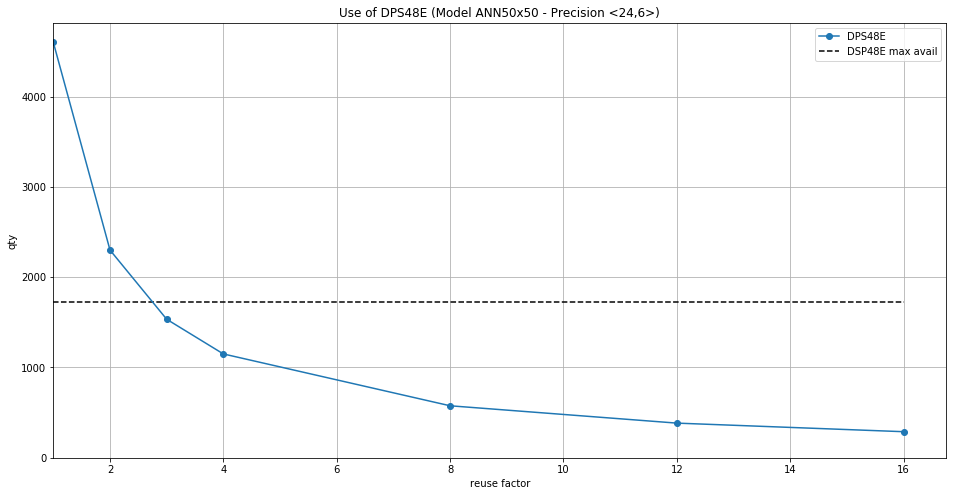

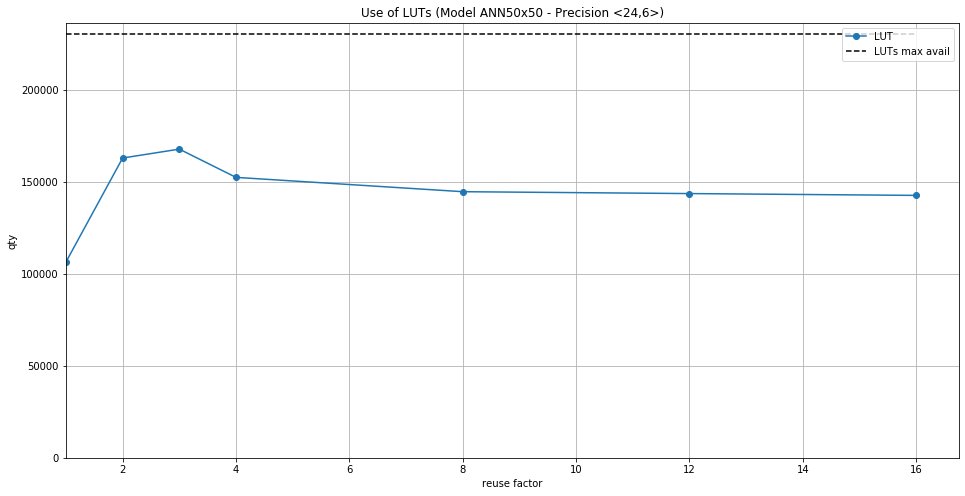

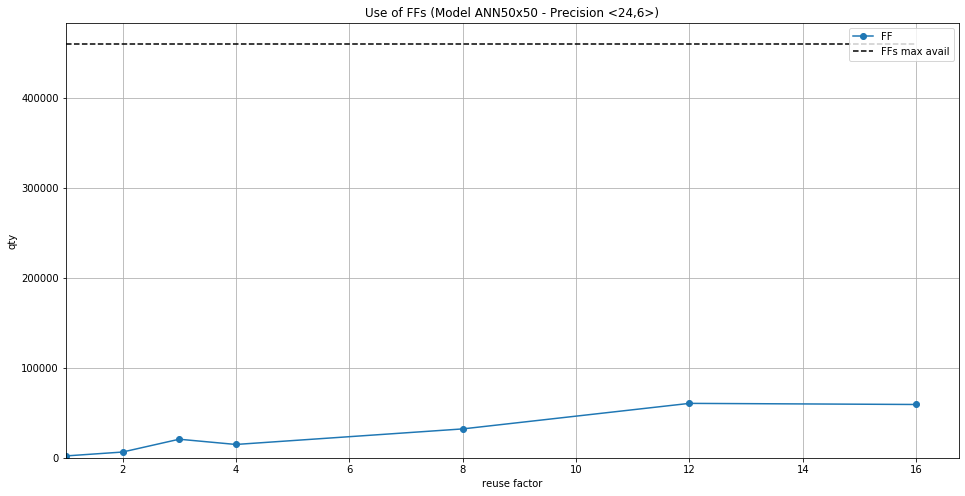

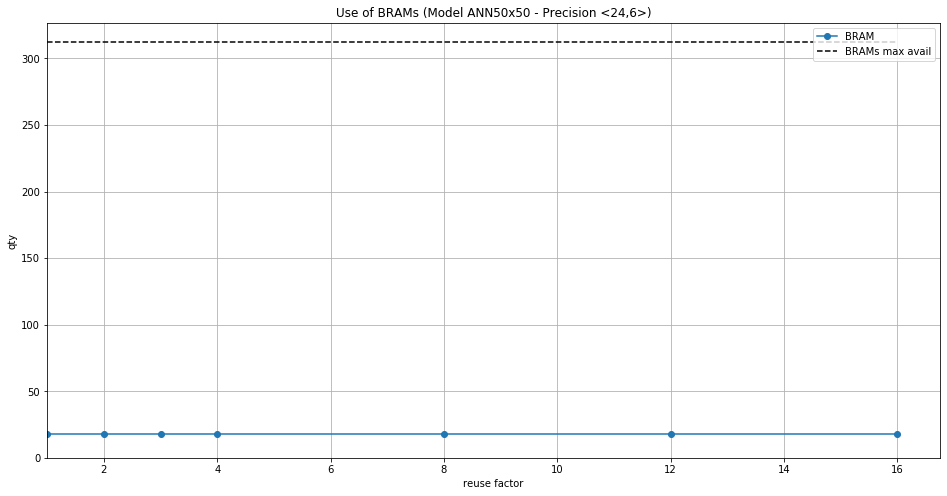

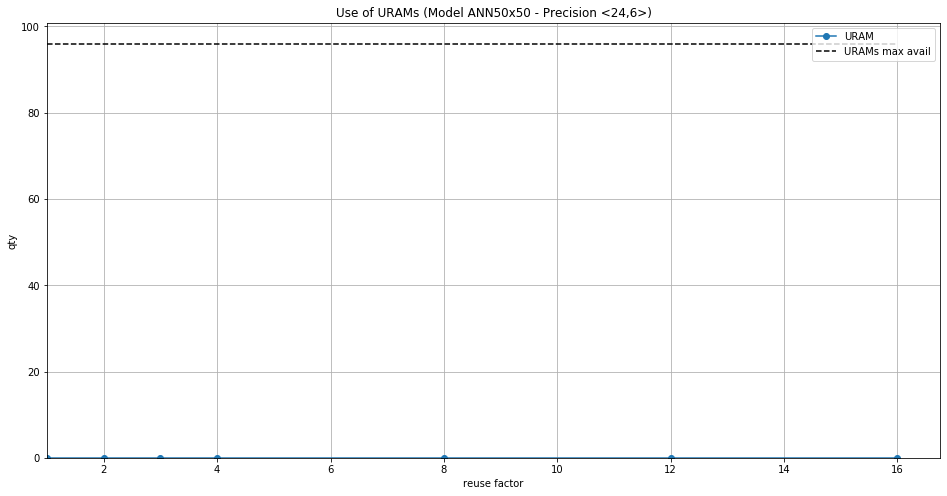

In [31]:
DPS48E = []
LUT = []
FF = []
BRAM = []
URAM = []
for i in range(len(REUSE_FACTOR)):
    DPS48E.append(int(reports[i]['Area']['DSP48E']))
    LUT.append(int(reports[i]['Area']['LUT']))
    FF.append(int(reports[i]['Area']['FF']))
    BRAM.append(int(reports[i]['Area']['BRAM_18K']))
    URAM.append(int(reports[i]['Area']['URAM']))

fig = plt.figure(figsize=(16,8))
plt.plot(REUSE_FACTOR, DPS48E, label='DPS48E', marker='o')
plt.hlines(DPS48E_max, np.min(REUSE_FACTOR), np.max(REUSE_FACTOR), linestyles='--', color='k', label='DSP48E max avail')
plt.xlabel('reuse factor')
plt.ylabel('qty')
plt.xlim(xmin=1)
plt.ylim(ymin=0)
plt.grid()
plt.legend()
plt.title('Use of DPS48E (Model {} - Precision <{},{}>)'.format(MODEL_NAME, PRECISION[0][0],PRECISION[0][1]))
fig.savefig(OUTPUT_FOLDER+'{}_p{}_{}_DPS48E.png'.format(MODEL_NAME, PRECISION[0][0],PRECISION[0][1]))
plt.show()

fig = plt.figure(figsize=(16,8))
plt.plot(REUSE_FACTOR, LUT, label='LUT', marker='o')
plt.hlines(LUT_max, np.min(REUSE_FACTOR), np.max(REUSE_FACTOR), linestyles='--', color='k', label='LUTs max avail')
plt.xlabel('reuse factor')
plt.ylabel('qty')
plt.xlim(xmin=1)
plt.ylim(ymin=0)
plt.grid()
plt.legend()
plt.title('Use of LUTs (Model {} - Precision <{},{}>)'.format(MODEL_NAME, PRECISION[0][0],PRECISION[0][1]))
fig.savefig(OUTPUT_FOLDER+'{}_p{}_{}_LUT.png'.format(MODEL_NAME, PRECISION[0][0],PRECISION[0][1]))
plt.show()

fig = plt.figure(figsize=(16,8))
plt.plot(REUSE_FACTOR, FF, label='FF', marker='o')
plt.hlines(FF_max, np.min(REUSE_FACTOR), np.max(REUSE_FACTOR), linestyles='--', color='k', label='FFs max avail')
plt.xlabel('reuse factor')
plt.ylabel('qty')
plt.xlim(xmin=1)
plt.ylim(ymin=0)
plt.grid()
plt.legend()
plt.title('Use of FFs (Model {} - Precision <{},{}>)'.format(MODEL_NAME, PRECISION[0][0],PRECISION[0][1]))
fig.savefig(OUTPUT_FOLDER+'{}_p{}_{}_FF.png'.format(MODEL_NAME, PRECISION[0][0],PRECISION[0][1]))
plt.show()


fig = plt.figure(figsize=(16,8))
plt.plot(REUSE_FACTOR, BRAM, label='BRAM', marker='o')
plt.hlines(BRAM_max, np.min(REUSE_FACTOR), np.max(REUSE_FACTOR), linestyles='--', color='k', label='BRAMs max avail')
plt.xlabel('reuse factor')
plt.ylabel('qty')
plt.xlim(xmin=1)
plt.ylim(ymin=0)
plt.grid()
plt.legend()
plt.title('Use of BRAMs (Model {} - Precision <{},{}>)'.format(MODEL_NAME, PRECISION[0][0],PRECISION[0][1]))
fig.savefig(OUTPUT_FOLDER+'{}_p{}_{}_BRAM.png'.format(MODEL_NAME, PRECISION[0][0],PRECISION[0][1]))
plt.show()

fig = plt.figure(figsize=(16,8))
plt.plot(REUSE_FACTOR, URAM, label='URAM', marker='o')
plt.hlines(URAM_max, np.min(REUSE_FACTOR), np.max(REUSE_FACTOR), linestyles='--', color='k', label='URAMs max avail')
plt.xlabel('reuse factor')
plt.ylabel('qty')
plt.xlim(xmin=1)
plt.ylim(ymin=0)
plt.grid()
plt.legend()
plt.title('Use of URAMs (Model {} - Precision <{},{}>)'.format(MODEL_NAME, PRECISION[0][0],PRECISION[0][1]))
fig.savefig(OUTPUT_FOLDER+'{}_p{}_{}_URAM.png'.format(MODEL_NAME, PRECISION[0][0],PRECISION[0][1]))
plt.show()

De las gicas anteriores se puede observar que los recursos que se vuelven críticos son: DSP48E y LUTs. Para REUSE_FACTOR = 1 y 2, no se podría usar este dispositivo. Notar también, que el uso del recurso DSP48E cae exponencialmente con el incremento del factor.

Un chequeo extra que se debe hacer es la *precisión* del modelo implementado en la FPGA. Como no se modifica la precisión númerica utilizada en la conversión, la performance de clasificación no debería verse afectada, pero por las dudas lo chequearemos.

Se graficarán tres curvas:
- FPGA acc: Precisión alcanzada por el modelo implementado en la FPGA.
- Model acc (golden model): Es la precisión alcanzada por el modelo original entrenado (los valores pueden variar a lo largo de las iteraciones pues se reentrena el modelo en cada corrida). Esta precisión equivale a usar cálculos con FLOAT32.
- FPGA best acc: Los datos que se pasan como entrada a la FPGA se les ha reducido la precisión (en general se usan 6 decimales, pero chequear el campo fpga_data_format en el reporte). Esta precisión es la que entrega el Golden Model con esos datos de entrada. Aquí se corrobora el máximo alcanzable por la FPGA y que la reducción de la precisión de los datos de entrada no esté afectando a la performance de manera significativa.

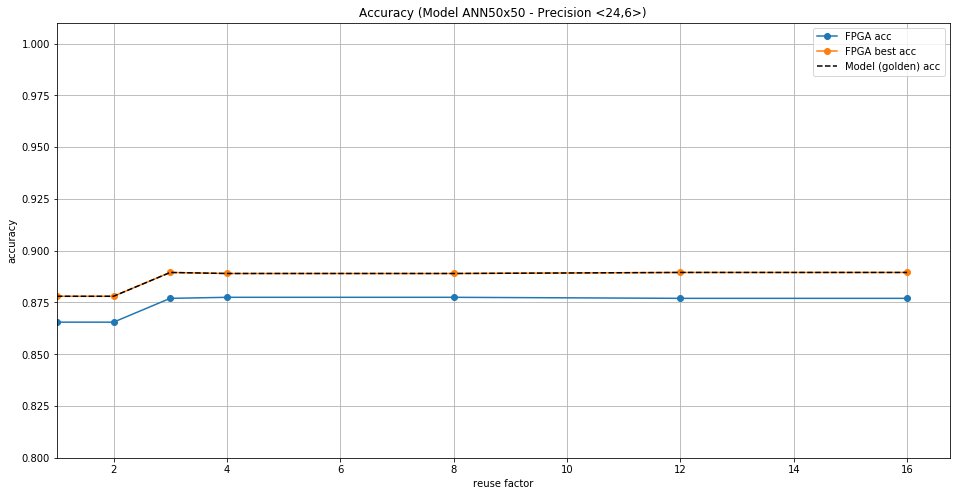

In [32]:
model_test_acc = []
fpga_acc = []
fpga_best_acc = []

for i in range(len(REUSE_FACTOR)):
    fpga_acc.append(reports[i]['acc']['fpga_acc'])
    fpga_best_acc.append(reports[i]['acc']['fpga_best_acc'])
    model_test_acc.append(reports[i]['acc']['model_test_acc'])

fig = plt.figure(figsize=(16,8))
plt.plot(REUSE_FACTOR, fpga_acc, label='FPGA acc', marker='o')
plt.plot(REUSE_FACTOR, fpga_best_acc, label='FPGA best acc', marker='o')
plt.plot(REUSE_FACTOR, model_test_acc, label='Model (golden) acc', marker='', linestyle='--', color='k')
plt.xlabel('reuse factor')
plt.ylabel('accuracy')
plt.xlim(xmin=1)
plt.ylim(ymin=0.8, ymax=1.01)
plt.grid()
plt.legend()
plt.title('Accuracy (Model {} - Precision <{},{}>)'.format(MODEL_NAME, PRECISION[0][0],PRECISION[0][1]))
fig.savefig(OUTPUT_FOLDER+'{}_p{}_{}_acc.png'.format(MODEL_NAME, PRECISION[0][0],PRECISION[0][1]))
plt.show()

## Precisión numérica - Sensibilidad al tamaño del entero
En esta sección se evalúa la sensisbilidad en los resultados al tamaño (cantidad de bits) para los enteros en la representación numérica. La precisión se especifica con dos campos $<N,D>$, donde $N$ representa la cantidad de bits totales para un valor numérico, mientras que $D$ es la cantidad de bits dedicado a la representación decimal del valor; por ende, $N-D$ es la cantidad de bits dedicada a la representación de la parte entera de los valores.

Una consideración importante es que es necesario ajustar la precisión numérica principalmente en función de dos criterios:
- Decimales: La cantidad de bits para los decimales impacta en la exactitud de los cálculos, teniendo un impacto directo en la performance. Este impacto es mayor en cuanto los pesos de la red tengan valores pequeños en general.
- Enteros: hay que elegir la cantidad necesaria de bits para los enteros en función de los valores más grandes (negativos o positivos), para prevenir la saturación en los cálculos.

Se puede proceder a inspeccionar los pesos de la red y la distribución de sus valores, y en función de ello ajustar la precisión numérica de la conversión. Otro camino es evaluar la performance de las conversiones variando los valores de precisión y viendo el comportamiento. Este último no es muy recomendado en la práctica ya que toma mucho tiempo realizar un conversión, síntesis y simulación, pero a los efectos ilustrativos del comportamiento se mostrarán los resultados de este último proceso.

El proceso ejecutado consistió en tomar una cantidad fija de bit para los decimales (en este caso 8 bits) e ir modificando la cantidad de bit para enteros, y consecuentemente la cantidad de bits total para la representación numérica. Es de esperar entonces, que a medida que se incremente la cantidad de bits para los enteros, mejore la performance pero que luego se establezca en un valor (cuando no tiene más sentido incrementar los bits para los enteros); así también es de esperar que suban los recursos utilizados en la FPGA a medida que se incrementa este parámetro.

Para todas las configuraciones se eligieron valores de *REUSE FACTOR* de 4 y 8, las cuales eran valores adecuados, según la sección anterior, para este componente. A su vez, se definió que la parte decimal de la palabra tendrá 6 bits.

In [33]:
MODEL_NAME = 'ANN50x50'
#PRECISION = [[36,8],[32, 8], [28,8], [24,8], [20,8], [16,8], [12,8]]
#REUSE_FACTOR = [1]

PRECISION = [[32,6], [28,6], [24,6], [20,6], [16,6], [12,6], [8,6]]
REUSE_FACTOR = [4,8]

PRECISION = PRECISION[::-1]
report_files_array = []

PRECISION_STR = ['<{},{}>'.format(p[0],p[1]) for p in PRECISION]

for r in REUSE_FACTOR:
    report_files = []
    for p in PRECISION:
        ITERATION_NAME = '{model_name}_p{p0}_{p1}_r{r}'.format(
            model_name=MODEL_NAME,
            p0=p[0],
            p1=p[1],
            r=r
        )  
        report_files.append( OUTPUT_FOLDER + ITERATION_NAME + '_report.json' )
    report_files_array.append(report_files)

In [34]:
reports_array = []
for rf in report_files_array:
    reports = []
    for report_file in rf:
        json_file = open(report_file)
        json_str = json_file.read()
        json_dict = json.loads(json_str)
        reports.append(json_dict)
    reports_array.append(reports)


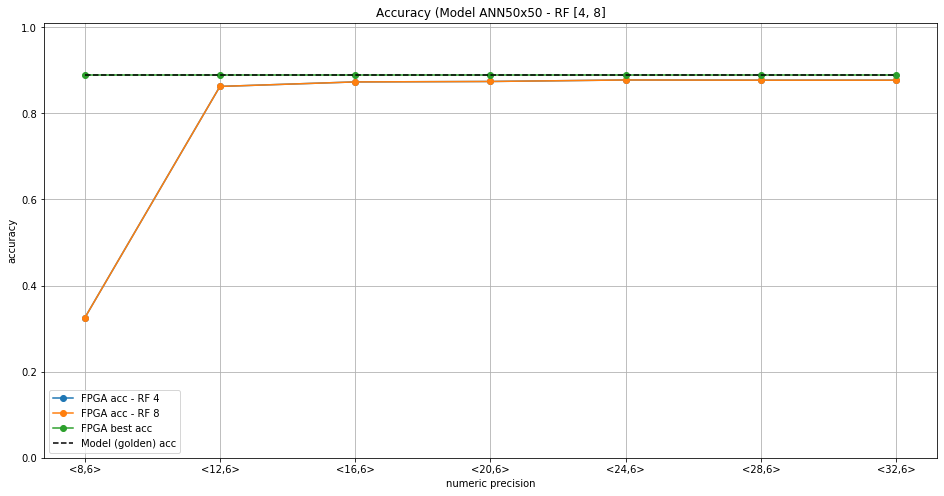

In [35]:
model_test_acc_array = []
fpga_acc_array = []
fpga_best_acc_array = []

for r in range(len(REUSE_FACTOR)):
    model_test_acc = []
    fpga_acc = []
    fpga_best_acc = []

    for i in range(len(PRECISION_STR)):
        fpga_acc.append(reports_array[r][i]['acc']['fpga_acc'])
        fpga_best_acc.append(reports_array[r][i]['acc']['fpga_best_acc'])
        model_test_acc.append(reports_array[r][i]['acc']['model_test_acc'])
    
    model_test_acc_array.append(model_test_acc)
    fpga_acc_array.append(fpga_acc)
    fpga_best_acc_array.append(fpga_best_acc)

fig = plt.figure(figsize=(16,8))
for r in range(len(REUSE_FACTOR)):
    plt.plot(PRECISION_STR, fpga_acc_array[r], label='FPGA acc - RF {}'.format(REUSE_FACTOR[r]), marker='o')
plt.plot(PRECISION_STR, fpga_best_acc, label='FPGA best acc', marker='o')
plt.plot(PRECISION_STR, model_test_acc, label='Model (golden) acc', marker='', linestyle='--', color='k')
plt.xlabel('numeric precision')
plt.ylabel('accuracy')
plt.ylim(ymin=0, ymax=1.01)
plt.grid()
plt.legend()
plt.title('Accuracy (Model {} - RF {}'.format(MODEL_NAME,REUSE_FACTOR))
fig.savefig(OUTPUT_FOLDER+'{}_int_r{}_acc.png'.format(MODEL_NAME,REUSE_FACTOR))
plt.show()

Notar que a partir de la precisión numérica $<12,6>$ no hay mejoras significativas en el desempeño, por lo que se puede concluir que no son necesarios más de 6 bits para la parte entera.

Veamos que pasa con otro de los parámetros importantes, la latencia. Es de esperar que se mantenga (prácticamente) constante, puesto que no se modifican las operaciones por ciclo de reloj.

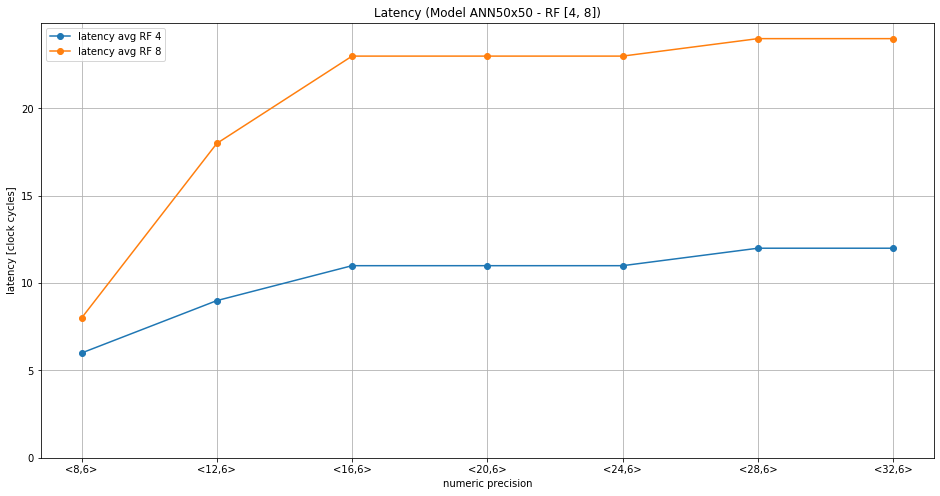

In [36]:
latency_avg_array = []
for r in range(len(REUSE_FACTOR)):
    latency_avg = []
    for i in range(len(PRECISION_STR)):
        latency_avg.append(int(reports_array[r][i]['Latency']['LatencyAvg']))
    latency_avg_array.append(latency_avg)

fig = plt.figure(figsize=(16,8))
for r in range(len(REUSE_FACTOR)):
    plt.plot(PRECISION_STR, latency_avg_array[r], label='latency avg RF {}'.format(REUSE_FACTOR[r]), marker='o')
plt.xlabel('numeric precision')
plt.ylabel('latency [clock cycles]')
plt.ylim(ymin=0)
plt.grid()
plt.legend()
plt.title('Latency (Model {} - RF {})'.format(MODEL_NAME, REUSE_FACTOR))
fig.savefig(OUTPUT_FOLDER+'{}_int_r{}_latency.png'.format(MODEL_NAME, REUSE_FACTOR))
plt.show()

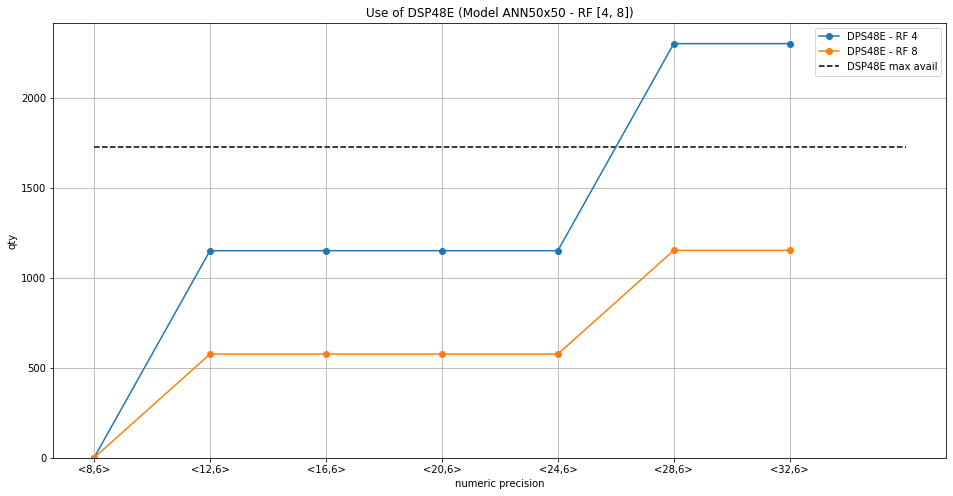

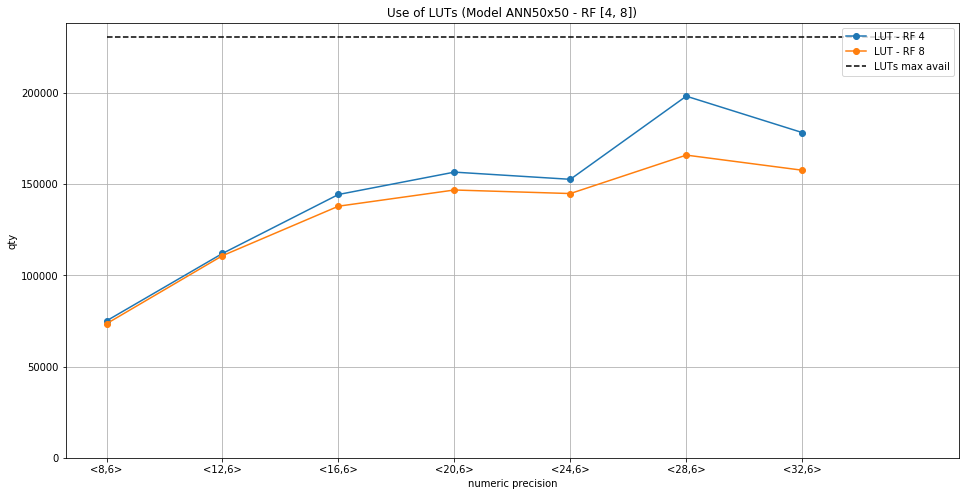

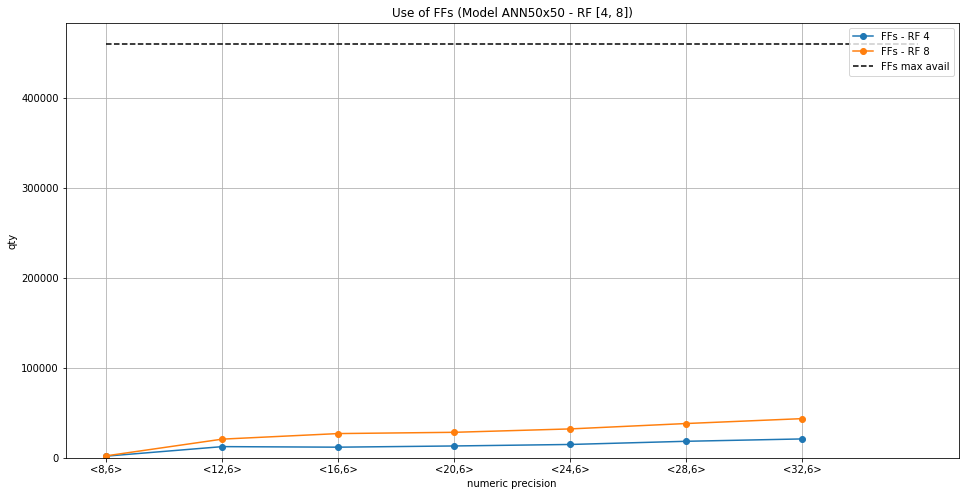

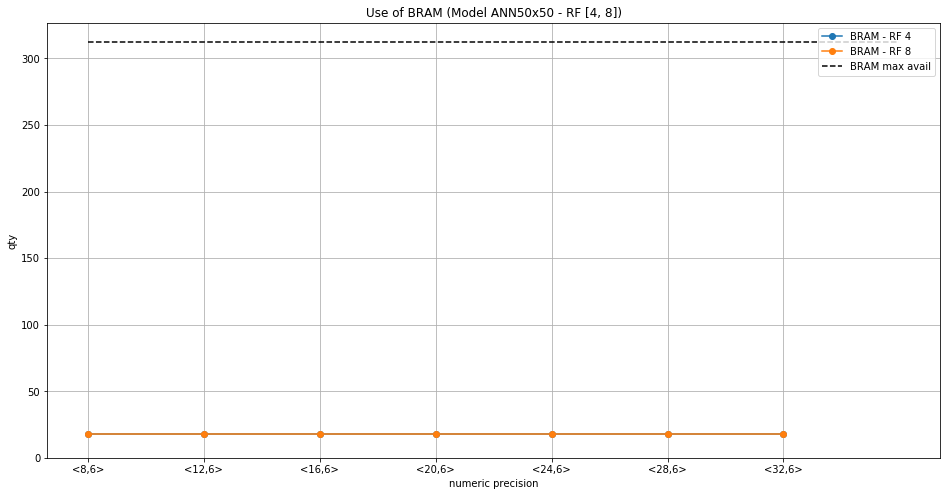

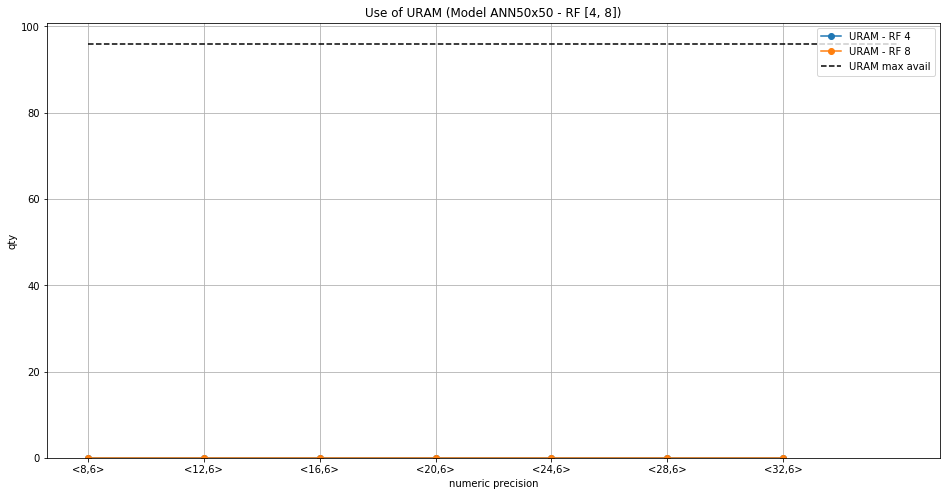

In [37]:
DPS48E_array = []
LUT_array = []
FF_array = []
BRAM_array = []
URAM_array = []
for r in range(len(REUSE_FACTOR)):
    DPS48E = []
    LUT = []
    FF = []
    BRAM = []
    URAM = []
    for i in range(len(PRECISION_STR)):
        DPS48E.append(int(reports_array[r][i]['Area']['DSP48E']))
        LUT.append(int(reports_array[r][i]['Area']['LUT']))
        FF.append(int(reports_array[r][i]['Area']['FF']))
        BRAM.append(int(reports_array[r][i]['Area']['BRAM_18K']))
        URAM.append(int(reports_array[r][i]['Area']['URAM']))
    DPS48E_array.append(DPS48E)
    LUT_array.append(LUT)
    FF_array.append(FF)
    BRAM_array.append(BRAM)
    URAM_array.append(URAM)

fig = plt.figure(figsize=(16,8))
for r in range(len(REUSE_FACTOR)):
    plt.plot(PRECISION_STR, DPS48E_array[r], label='DPS48E - RF {}'.format(REUSE_FACTOR[r]), marker='o')
plt.hlines(DPS48E_max, 0, len(PRECISION_STR), linestyles='--', color='k', label='DSP48E max avail')
plt.xlabel('numeric precision')
plt.ylabel('qty')
plt.ylim(ymin=0)
plt.grid()
plt.legend()
plt.title('Use of DSP48E (Model {} - RF {})'.format(MODEL_NAME, REUSE_FACTOR))
fig.savefig(OUTPUT_FOLDER+'{}_int_r{}_DSP48E.png'.format(MODEL_NAME, REUSE_FACTOR))
plt.show()

fig = plt.figure(figsize=(16,8))
for r in range(len(REUSE_FACTOR)):
    plt.plot(PRECISION_STR, LUT_array[r], label='LUT - RF {}'.format(REUSE_FACTOR[r]), marker='o')
plt.hlines(LUT_max, 0, len(PRECISION_STR), linestyles='--', color='k', label='LUTs max avail')
plt.xlabel('numeric precision')
plt.ylabel('qty')
plt.ylim(ymin=0)
plt.grid()
plt.legend()
plt.title('Use of LUTs (Model {} - RF {})'.format(MODEL_NAME, REUSE_FACTOR))
fig.savefig(OUTPUT_FOLDER+'{}_int_r{}_LUT.png'.format(MODEL_NAME, REUSE_FACTOR))
plt.show()

fig = plt.figure(figsize=(16,8))
for r in range(len(REUSE_FACTOR)):
    plt.plot(PRECISION_STR, FF_array[r], label='FFs - RF {}'.format(REUSE_FACTOR[r]), marker='o')
plt.hlines(FF_max, 0, len(PRECISION_STR), linestyles='--', color='k', label='FFs max avail')
plt.xlabel('numeric precision')
plt.ylabel('qty')
plt.ylim(ymin=0)
plt.grid()
plt.legend()
plt.title('Use of FFs (Model {} - RF {})'.format(MODEL_NAME, REUSE_FACTOR))
fig.savefig(OUTPUT_FOLDER+'{}_int_r{}_FFE.png'.format(MODEL_NAME, REUSE_FACTOR))
plt.show()


fig = plt.figure(figsize=(16,8))
for r in range(len(REUSE_FACTOR)):
    plt.plot(PRECISION_STR, BRAM_array[r], label='BRAM - RF {}'.format(REUSE_FACTOR[r]), marker='o')
plt.hlines(BRAM_max, 0, len(PRECISION_STR), linestyles='--', color='k', label='BRAM max avail')
plt.xlabel('numeric precision')
plt.ylabel('qty')
plt.ylim(ymin=0)
plt.grid()
plt.legend()
plt.title('Use of BRAM (Model {} - RF {})'.format(MODEL_NAME, REUSE_FACTOR))
fig.savefig(OUTPUT_FOLDER+'{}_int_r{}_BRAM.png'.format(MODEL_NAME, REUSE_FACTOR))
plt.show()

fig = plt.figure(figsize=(16,8))
for r in range(len(REUSE_FACTOR)):
    plt.plot(PRECISION_STR, URAM_array[r], label='URAM - RF {}'.format(REUSE_FACTOR[r]), marker='o')
plt.hlines(URAM_max, 0, len(PRECISION_STR), linestyles='--', color='k', label='URAM max avail')
plt.xlabel('numeric precision')
plt.ylabel('qty')
plt.ylim(ymin=0)
plt.grid()
plt.legend()
plt.title('Use of URAM (Model {} - RF {})'.format(MODEL_NAME, REUSE_FACTOR))
fig.savefig(OUTPUT_FOLDER+'{}_int_r{}_URAM.png'.format(MODEL_NAME, REUSE_FACTOR))
plt.show()

## Precisión numérica - Sensibilidad al tamaño del decimal
En este caso se hará el mismo análisis que en la sección anterior, pero en este caso se mantendrá constante la cantidad de bits dedicados a la parte entera (6 bits) en este caso, para luego ir variando la cantidad de bits dedicada a la parte decimal de la palabra.

In [38]:
MODEL_NAME = 'ANN50x50'
PRECISION = [[32,26], [28,22], [24,18], [20,14], [16,10], [12,6], [8,2]]
REUSE_FACTOR = [4,8]
PRECISION = PRECISION[::-1]
report_files_array = []

PRECISION_STR = ['<{},{}>'.format(p[0],p[1]) for p in PRECISION]

for r in REUSE_FACTOR:
    report_files = []
    for p in PRECISION:
        ITERATION_NAME = '{model_name}_p{p0}_{p1}_r{r}'.format(
            model_name=MODEL_NAME,
            p0=p[0],
            p1=p[1],
            r=r
        )  
        report_files.append( OUTPUT_FOLDER + ITERATION_NAME + '_report.json' )
    report_files_array.append(report_files)

In [39]:
reports_array = []
for rf in report_files_array:
    reports = []
    for report_file in rf:
        json_file = open(report_file)
        json_str = json_file.read()
        json_dict = json.loads(json_str)
        reports.append(json_dict)
    reports_array.append(reports)


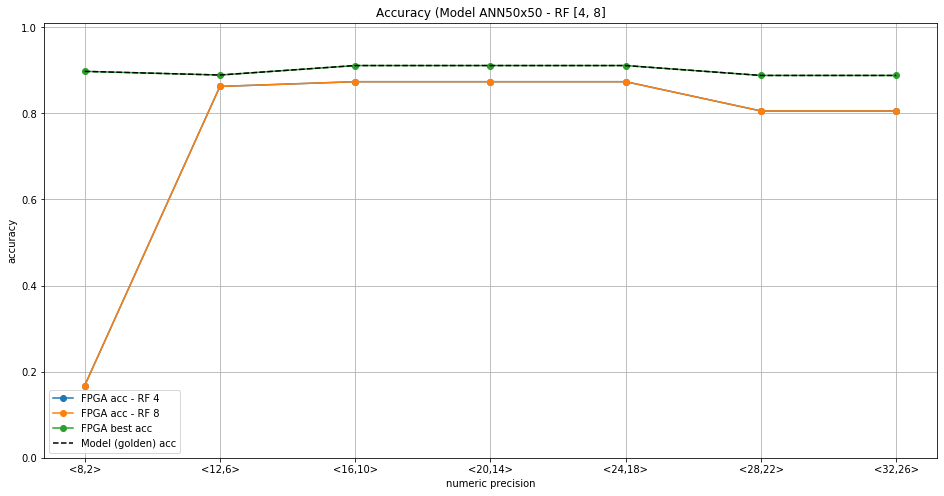

In [40]:
model_test_acc_array = []
fpga_acc_array = []
fpga_best_acc_array = []

for r in range(len(REUSE_FACTOR)):
    model_test_acc = []
    fpga_acc = []
    fpga_best_acc = []

    for i in range(len(PRECISION_STR)):
        fpga_acc.append(reports_array[r][i]['acc']['fpga_acc'])
        fpga_best_acc.append(reports_array[r][i]['acc']['fpga_best_acc'])
        model_test_acc.append(reports_array[r][i]['acc']['model_test_acc'])
    
    model_test_acc_array.append(model_test_acc)
    fpga_acc_array.append(fpga_acc)
    fpga_best_acc_array.append(fpga_best_acc)

fig = plt.figure(figsize=(16,8))
for r in range(len(REUSE_FACTOR)):
    plt.plot(PRECISION_STR, fpga_acc_array[r], label='FPGA acc - RF {}'.format(REUSE_FACTOR[r]), marker='o')
plt.plot(PRECISION_STR, fpga_best_acc, label='FPGA best acc', marker='o')
plt.plot(PRECISION_STR, model_test_acc, label='Model (golden) acc', marker='', linestyle='--', color='k')
plt.xlabel('numeric precision')
plt.ylabel('accuracy')
plt.ylim(ymin=0, ymax=1.01)
plt.grid()
plt.legend()
plt.title('Accuracy (Model {} - RF {}'.format(MODEL_NAME,REUSE_FACTOR))
fig.savefig(OUTPUT_FOLDER+'{}_int_r{}_acc.png'.format(MODEL_NAME,REUSE_FACTOR))
plt.show()

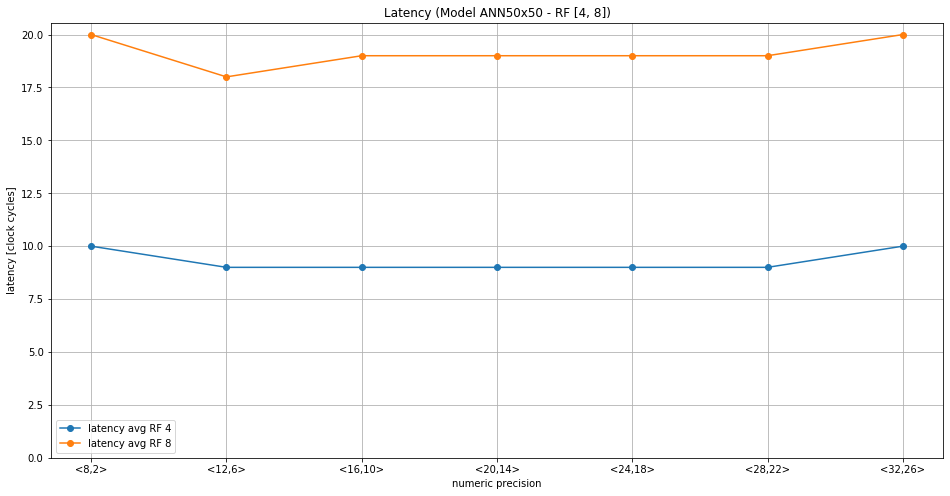

In [41]:
latency_avg_array = []
for r in range(len(REUSE_FACTOR)):
    latency_avg = []
    for i in range(len(PRECISION_STR)):
        latency_avg.append(int(reports_array[r][i]['Latency']['LatencyAvg']))
    latency_avg_array.append(latency_avg)

fig = plt.figure(figsize=(16,8))
for r in range(len(REUSE_FACTOR)):
    plt.plot(PRECISION_STR, latency_avg_array[r], label='latency avg RF {}'.format(REUSE_FACTOR[r]), marker='o')
plt.xlabel('numeric precision')
plt.ylabel('latency [clock cycles]')
plt.ylim(ymin=0)
plt.grid()
plt.legend()
plt.title('Latency (Model {} - RF {})'.format(MODEL_NAME, REUSE_FACTOR))
fig.savefig(OUTPUT_FOLDER+'{}_int_r{}_latency.png'.format(MODEL_NAME, REUSE_FACTOR))
plt.show()

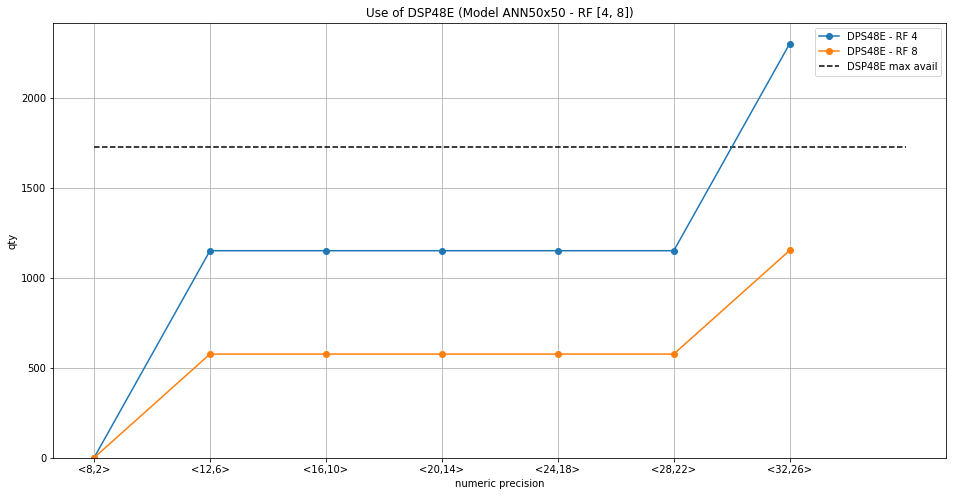

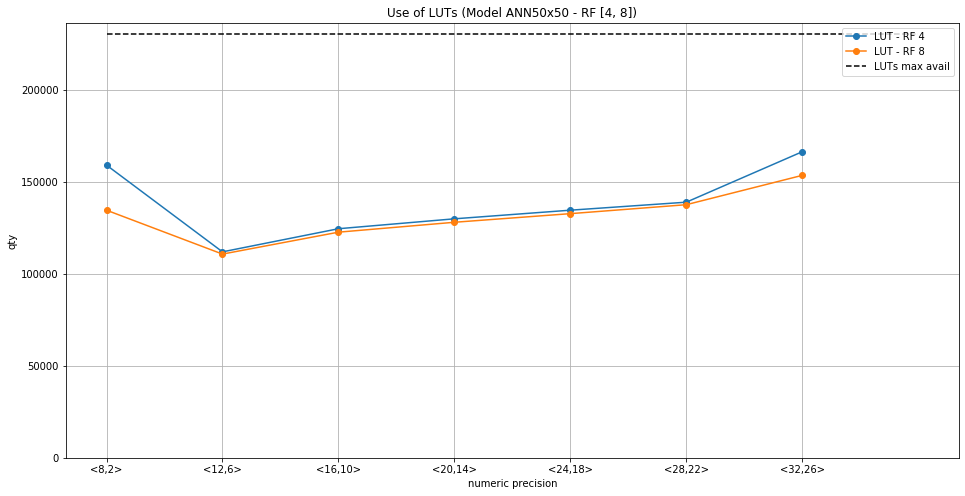

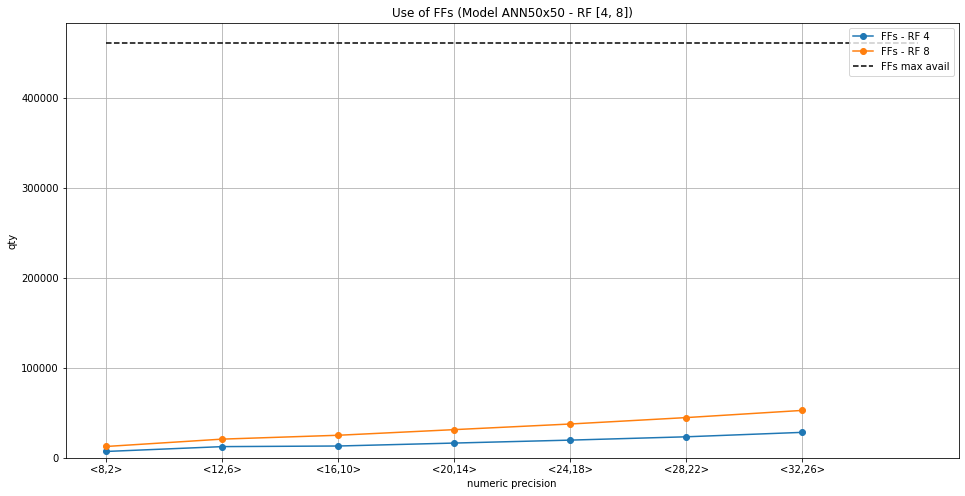

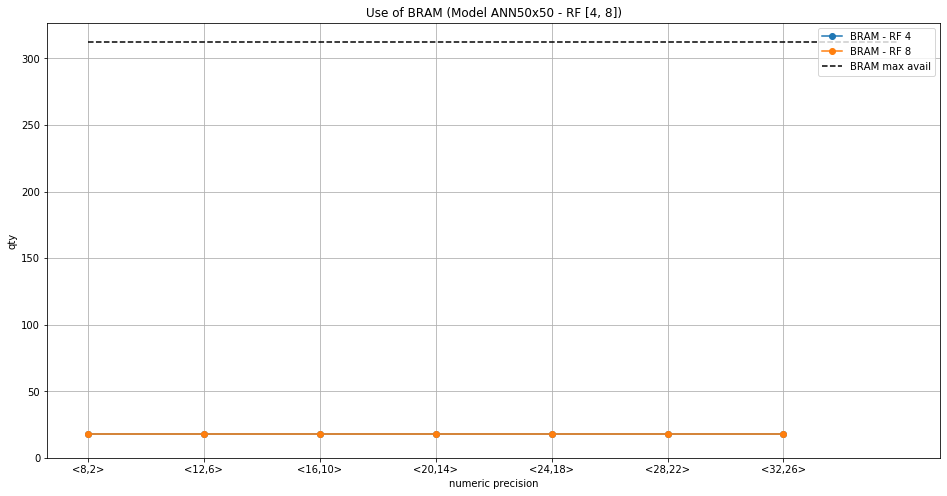

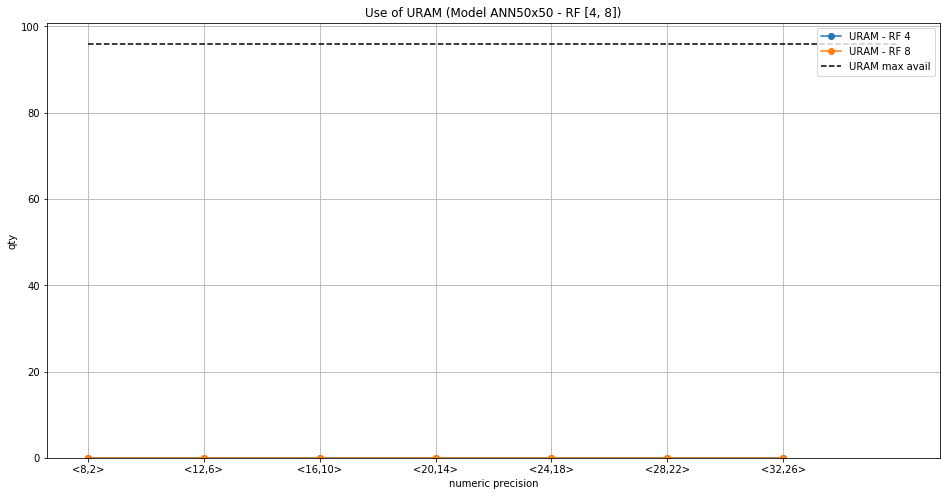

In [42]:
DPS48E_array = []
LUT_array = []
FF_array = []
BRAM_array = []
URAM_array = []
for r in range(len(REUSE_FACTOR)):
    DPS48E = []
    LUT = []
    FF = []
    BRAM = []
    URAM = []
    for i in range(len(PRECISION_STR)):
        DPS48E.append(int(reports_array[r][i]['Area']['DSP48E']))
        LUT.append(int(reports_array[r][i]['Area']['LUT']))
        FF.append(int(reports_array[r][i]['Area']['FF']))
        BRAM.append(int(reports_array[r][i]['Area']['BRAM_18K']))
        URAM.append(int(reports_array[r][i]['Area']['URAM']))
    DPS48E_array.append(DPS48E)
    LUT_array.append(LUT)
    FF_array.append(FF)
    BRAM_array.append(BRAM)
    URAM_array.append(URAM)

fig = plt.figure(figsize=(16,8))
for r in range(len(REUSE_FACTOR)):
    plt.plot(PRECISION_STR, DPS48E_array[r], label='DPS48E - RF {}'.format(REUSE_FACTOR[r]), marker='o')
plt.hlines(DPS48E_max, 0, len(PRECISION_STR), linestyles='--', color='k', label='DSP48E max avail')
plt.xlabel('numeric precision')
plt.ylabel('qty')
plt.ylim(ymin=0)
plt.grid()
plt.legend()
plt.title('Use of DSP48E (Model {} - RF {})'.format(MODEL_NAME, REUSE_FACTOR))
fig.savefig(OUTPUT_FOLDER+'{}_int_r{}_DSP48E.png'.format(MODEL_NAME, REUSE_FACTOR))
plt.show()

fig = plt.figure(figsize=(16,8))
for r in range(len(REUSE_FACTOR)):
    plt.plot(PRECISION_STR, LUT_array[r], label='LUT - RF {}'.format(REUSE_FACTOR[r]), marker='o')
plt.hlines(LUT_max, 0, len(PRECISION_STR), linestyles='--', color='k', label='LUTs max avail')
plt.xlabel('numeric precision')
plt.ylabel('qty')
plt.ylim(ymin=0)
plt.grid()
plt.legend()
plt.title('Use of LUTs (Model {} - RF {})'.format(MODEL_NAME, REUSE_FACTOR))
fig.savefig(OUTPUT_FOLDER+'{}_int_r{}_LUT.png'.format(MODEL_NAME, REUSE_FACTOR))
plt.show()

fig = plt.figure(figsize=(16,8))
for r in range(len(REUSE_FACTOR)):
    plt.plot(PRECISION_STR, FF_array[r], label='FFs - RF {}'.format(REUSE_FACTOR[r]), marker='o')
plt.hlines(FF_max, 0, len(PRECISION_STR), linestyles='--', color='k', label='FFs max avail')
plt.xlabel('numeric precision')
plt.ylabel('qty')
plt.ylim(ymin=0)
plt.grid()
plt.legend()
plt.title('Use of FFs (Model {} - RF {})'.format(MODEL_NAME, REUSE_FACTOR))
fig.savefig(OUTPUT_FOLDER+'{}_int_r{}_FFE.png'.format(MODEL_NAME, REUSE_FACTOR))
plt.show()


fig = plt.figure(figsize=(16,8))
for r in range(len(REUSE_FACTOR)):
    plt.plot(PRECISION_STR, BRAM_array[r], label='BRAM - RF {}'.format(REUSE_FACTOR[r]), marker='o')
plt.hlines(BRAM_max, 0, len(PRECISION_STR), linestyles='--', color='k', label='BRAM max avail')
plt.xlabel('numeric precision')
plt.ylabel('qty')
plt.ylim(ymin=0)
plt.grid()
plt.legend()
plt.title('Use of BRAM (Model {} - RF {})'.format(MODEL_NAME, REUSE_FACTOR))
fig.savefig(OUTPUT_FOLDER+'{}_int_r{}_BRAM.png'.format(MODEL_NAME, REUSE_FACTOR))
plt.show()

fig = plt.figure(figsize=(16,8))
for r in range(len(REUSE_FACTOR)):
    plt.plot(PRECISION_STR, URAM_array[r], label='URAM - RF {}'.format(REUSE_FACTOR[r]), marker='o')
plt.hlines(URAM_max, 0, len(PRECISION_STR), linestyles='--', color='k', label='URAM max avail')
plt.xlabel('numeric precision')
plt.ylabel('qty')
plt.ylim(ymin=0)
plt.grid()
plt.legend()
plt.title('Use of URAM (Model {} - RF {})'.format(MODEL_NAME, REUSE_FACTOR))
fig.savefig(OUTPUT_FOLDER+'{}_int_r{}_URAM.png'.format(MODEL_NAME, REUSE_FACTOR))
plt.show()